In [ ]:
import numpy as np

#Bernouilli NB
- NB classifiers are generative algoritmhs that use Baye's rule to predict classes.
- Used in Spam filtering generally.
- Bernoulli NB classifier works on binary classification problem.
- Class conditional density and prior depends on the underlying distribution while the evidence remaions the same.
- posterior = prior*likelihood/evidence
- In case of Bernoulli NB, class conditional density equates to the average of feature value xj in examples with label yc.
- Class prior is the total number of samples with class yc divided by total number of samples.

In [ ]:
def fit(X,y):
    n_samples, n_features = X.shape
    class_count = np.unique(y)
    n_classes = len(class_count)

    w = np.zeros((n_classes,n_features),dtype=np.float64)
    w_priors = np.zeros(n_classes, dtype = np.float64) 

    for c in range(n_classes):
        # Parameters with label = c
        X_c = X[y == c]

        #Class conditional density
        w[c,:] = np.sum(X_c, axis=0)/X_c.shape[0] 

        # Class prior
        w_priors[c] = X_c.shape[0]/float(n_samples)

        return w, w_priors

In [ ]:
X = np.array([[1,0],[0,1],[0,1],[1,0]])
y = np.array([1,0,0,1])
print(fit(X,y))

(array([[0., 1.],
       [0., 0.]]), array([0.5, 0. ]))


In [ ]:
class BernoulliNB(object):
    def __init__(self,alpha=1.0):
        self.alpha = alpha 

    def fit(self,X,y):
        n_samples, n_features = X.shape
        class_count = np.unique(y)
        n_classes = len(class_count)

        self.w = np.zeros((n_classes,n_features),dtype=np.float64)
        self.w_priors = np.zeros(n_classes, dtype = np.float64) 

        for c in range(n_classes):
            X_c = X[y==c]
            self.w[c,:] = (np.sum(X_c, axis=0)+self.alpha)/(X_c.shape[0] 
                           + 2*self.alpha)
            self.w_priors[c] = ((X_c.shape[0] + self.alpha)/
                             (float(n_samples) + n_classes*self.alpha))
        
        print("Class conditional density: ",self.w)
        print("Class prior: ",self.w_priors)
    
    def log_likelihood_prior_prod(self,X):
        return (X@(np.log(self.w).T)+(1-X)@(np.log(1-self.w).T)
        +np.log(self.w_priors))

    def predict_prob(self,X):
        q = self.log_likelihood_prior_prod(X)
        return np.exp(q)/np.expand_dims(np.sum(np.exp(q),axis=1),axis=1)
    
    def predict(self,X):
        return np.argmax(self.log_likelihood_prior_prod(X),axis=1)


#Demonstration

In [ ]:
nb = BernoulliNB()
nb.fit(X,y)

Class conditional density:  [[0.25 0.75]
 [0.75 0.25]]
Class prior:  [0.5 0.5]


In [ ]:
nb.predict(X)

array([1, 0, 0, 1])

In [ ]:
nb.predict_prob(X)

array([[0.1, 0.9],
       [0.9, 0.1],
       [0.9, 0.1],
       [0.1, 0.9]])

In [ ]:
nb.log_likelihood_prior_prod(X)

array([[-3.4657359 , -1.26851133],
       [-1.26851133, -3.4657359 ],
       [-1.26851133, -3.4657359 ],
       [-3.4657359 , -1.26851133]])

##Multiclass classification setup

In [ ]:
X = np.array([[1,0],[1,0],[0,1],[1,0],[0,1],[0,0],[0,0],[1,1],[1,1],[1,0]])
y = np.array([1,0,2,0,2,1,0,0,2,1])

In [ ]:
NB = BernoulliNB(alpha=2.5)
NB.fit(X,y)

Class conditional density:  [[0.61111111 0.38888889]
 [0.5625     0.3125    ]
 [0.4375     0.6875    ]]
Class prior:  [0.37142857 0.31428571 0.31428571]


In [ ]:
NB.predict(X)

array([0, 0, 2, 0, 2, 1, 1, 2, 2, 0])

#Gaussian Naive Bayes
- Features are continuous and the underlying assumption is that the labels come from a gaussian distribution.
- We use multivarite Gaussian distribution reprerantion for efficient computation. 
- It involves a mean vector and the coviarance matrix(diagonal only) to represent the model.
- posterior = prior*likelihood/evidence  

In [ ]:
class GaussianNB(object):

    def fit(self,X,y):
        n_samples, n_features = X.shape
        self._classes = np.unique(y)
        n_classes = len(self._classes)

        self._mean = np.zeros((n_classes,n_features), dtype=np.float64)
        self._var = np.zeros((n_classes,n_features), dtype=np.float64)
        self._priors = np.zeros(n_classes, dtype=np.float64)

        for idx,c in enumerate(self._classes):
            X_c = X[y == c]

            self._mean[idx,:] = X_c.mean(axis=0)
            self._var[idx,:] = X_c.var(axis=0)
            self._priors[idx] = X_c.shape[0]/float(n_samples)

        print("Mean: ", self._mean)
        print("Variance: ",self._var)
        print("Priors: ",self._priors)
    
    def _calc_pdf(self,class_idx,X):
        mean = self._mean[class_idx]
        var = np.diag(self._var[class_idx])
        z = np.power(2*np.pi, X.shape[0]/2)*np.power(np.linalg.det(var),1/2)
        return (1/z)*np.exp(-0.5*np.transpose(X - mean)@(np.linalg.inv(var)@(X-mean)))

    def _calc_prod_likelihood_prior(self,X):
        self._prod_likelihood_prior = np.zeros((X.shape[0],len(self._classes)),dtype=np.float64)

        for x_idx,x in enumerate(X):
            for idx,c in enumerate(self._classes):
                self._prod_likelihood_prior = (np.log(self._calc_pdf(idx,x)) + np.log(self._priors[idx]))
    
    def predict(self,X):
        self._calc_prod_likelihood_prior(X)
        return np.argmax(self._prod_likelihood_prior,axis=1)

    def predict_prob(self,X):
        self._calc_prod_likelihood_prior(X)
        return (np.exp(self._prod_likelihood_prior)/ 
                np.expand_dims(np.sim(np.exp(self._prod_likelihood_prior),axis=1),axis=1))


#Demonstration

In [ ]:
from sklearn.datasets import make_classification,make_blobs
from sklearn.model_selection import train_test_split 

X,y = make_blobs(n_samples=100,
                 n_features=2,
                 centers=[[3,3],[7,7]],
                 cluster_std=2.0,
                 random_state=10)

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=1111)


In [ ]:
gnb = GaussianNB()
gnb.fit(X_train,y_train)

Mean:  [[3.32482422 2.99925374]
 [7.38479102 6.82884038]]
Variance:  [[3.54023816 3.81810434]
 [3.83642641 2.84726561]]
Priors:  [0.4625 0.5375]


<Figure size 864x576 with 0 Axes>

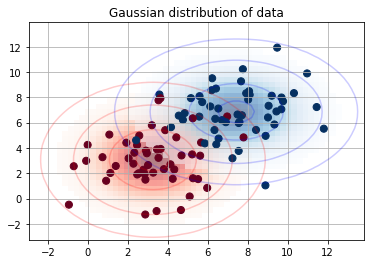

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12,8))
fig, ax = plt.subplots()
ax.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='RdBu')

xlim = (min(X[:, 0])-2, max(X[:, 0])+2)
ylim = (min(X[:, 1])-2, max(X[:, 1])+2)

xg = np.linspace(xlim[0], xlim[1], 60)
yg = np.linspace(ylim[0], ylim[1], 40)

xx, yy = np.meshgrid(xg, yg)
Xgrid = np.vstack([xx.ravel(), yy.ravel()]).T


for label, color in enumerate(['red', 'blue']):
    mask = (y == label)
    mu, std = X[mask].mean(0), X[mask].std(0)
    P = np.exp(-0.5 * (Xgrid - mu)**2 / std**2).prod(1)
    Pm = np.ma.masked_array(P, P < 0.03)
    ax.pcolorfast(xg, yg, Pm.reshape(xx.shape),
                alpha=0.5, cmap=color.title()+'s')
    ax.contour(xx, yy, P.reshape(xx.shape), levels=[
                0.01, 0.1, 0.5, 0.9], colors=color, alpha=0.2)

ax.set(xlim=xlim, ylim=ylim)
plt.grid()
plt.title("Gaussian distribution of data")
plt.show()

In [ ]:
gnb.predict(X_test)

AxisError: ignored